# Aggregation module

### Input: 

aggregation_input.csv

### Output:

dataset.csv: a dataset of natural language descriptions

aggregated_by_group.txt: the description information aggregated by words, sentences, word frequencies, and clusters


In [52]:
import pandas as pd
import json
from sklearn import cluster
from sklearn import metrics
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import ast

In [57]:
def getData(path):
  return pd.read_csv(path)

def flattenList(lst):
  return [item for sublist in lst for item in sublist]

def getSentences(df, group='all'):
  if group != 'all':
    df = df[df['group'] == group]


  descriptions = df.descriptions.values
  descriptions = [ast.literal_eval(lst) for lst in descriptions]

  descriptions = flattenList(descriptions)

  return descriptions

def getWords(df, group='all'):
  sentences = getSentences(df, group)

  words = [i.split() for i in sentences]
  words = flattenList(words)
  words = [word.lower() for word in words]

  return words

def wordsByFreq(df, group='all'):
  words = getWords(df, group)

  freq = {}
  for word in words:
    if word not in freq:
      freq[word] = 0
    freq[word] += 1

  return freq

# Embeddings and clustering 

Using glove.6V.50d embeddings


In [61]:
def deleteUninterestingWords(words):
  uninteresting_words = ['a', 'the', 'they', 'it', 'and', 'to']

  new_words = []
  for word in words:
    if word not in uninteresting_words:
      new_words.append(word)

  return new_words


def getEmbeddingsDict():  
  embeddings_dict = {}

  with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      embeddings_dict[word] = vector

  return embeddings_dict


def getEmbeddings(words, dic=None):
  if dic is None:
    dic = getEmbeddingsDict()

  new_embed = {}

  for word in words:
    new_embed[word] = dic[word]

  return new_embed


def cluster_embeddings(X, num=4):
  kclusterer = KMeansClusterer(num, distance=spatial.distance.cosine, repeats=25, avoid_empty_clusters=True)
  kmeans = kclusterer.cluster(X, assign_clusters=True)
  return kmeans

def sortClusters(kmeans, words):
  sorted_words = {}
  #words = list(model.wv.vocab)
  for i, word in enumerate(words):
    c = kmeans[i]  
    if c not in sorted_words:
      sorted_words[c] = []
    sorted_words[c].append(word)
    #print (word + ":" + str(kmeans[i]))
  return sorted_words

In [38]:
def getClusters(df, group):
  words = getWords(df)
  words = deleteUninterestingWords(words)
  embeddings = getEmbeddings(words, all_embeddings)
  vectors = [embeddings[word] for word in words]

  kmeans = cluster_embeddings(vectors, 4)
  clusters = sortClusters(kmeans, words)

  return clusters


# Put data into correct format

In [39]:
def makeDataHolder(df, group='all'):
  x = {
      'sentences': getSentences(df, group),
       'words': getWords(df, group),
       'freq': wordsByFreq(df, group),
       'clusters': getClusters(df, group),
  }

  return x


def splitDataByGroup(df):
  by_group = {}

  by_group['all'] = makeDataHolder(df, 'all')

  for group in range(1, 8):
    by_group[group] = makeDataHolder(df, group)

  return by_group

In [63]:
def makeAvatarDataset(df):
  # final columns are og_image, updated_image, group, description

  df = df.explode('descriptions')

  df['description'] = df['descriptions']
  df = df[["og_image", "updated_image", "set", "group", "description"]]

  return df

# Overall functions to retrieve data

In [41]:
# The embedding dictionary. This is a general glove embedding
all_embeddings = getEmbeddingsDict()


In [42]:
# get data
df = getData("aggregation_input.csv")

In [58]:
# get the data for each group
by_group = splitDataByGroup(df)

In [64]:
# format the results into a dataset
dataset = makeAvatarDataset(df)

In [67]:
# save the data
with open('aggregated_by_group.txt', 'w+') as f:
  json.dump(by_group, f)


dataset.to_csv('dataset.csv')



# Old version attempting with clustering! TAs please ignore below here

Input: csv with group number, the given word, and if the word is valid.


### Notes
Using word2vec and not glove to find independent embeddings

In [65]:
dataset

,og_image,updated_image,set,group,description
0,https://i.postimg.cc/3wvyVHpd/Avatar-Maker.png,https://i.postimg.cc/7ZcGKL5F/Avatar-Maker-1.png,1,1,['Change the eyebrows to be thicker']
1,https://i.postimg.cc/3wvyVHpd/Avatar-Maker.png,https://i.postimg.cc/ydCJzrXn/Avatar-Maker-2.png,1,2,['Change the eyebrows to arch up']
2,https://i.postimg.cc/3wvyVHpd/Avatar-Maker.png,https://i.postimg.cc/vB748L0y/Avatar-Maker-3.png,1,3,[]
3,https://i.postimg.cc/3wvyVHpd/Avatar-Maker.png,https://i.postimg.cc/XvLMVr9h/Avatar-Maker-4.png,1,4,"['Change the eyebrow shape', 'Change the eye s..."
4,https://i.postimg.cc/3wvyVHpd/Avatar-Maker.png,https://i.postimg.cc/2yqgFTgR/Avatar-Maker-5.png,1,5,['Change the eye shape to be bigger']
5,https://i.postimg.cc/3wvyVHpd/Avatar-Maker.png,https://i.postimg.cc/FRHM1hZK/Avatar-Maker-6.png,1,6,[]
6,https://i.postimg.cc/3wvyVHpd/Avatar-Maker.png,https://i.postimg.cc/fLq6912f/Avatar-Maker-7.png,1,7,"['Change the eyebrow thickness', 'Change the m..."
7,https://i.postimg.cc/kGqP9Wpk/Avatar-Maker.png,https://i.postimg.cc/0yBvmMzw/Avatar-Maker-1.png,2,1,[]
8,https://i.postimg.cc/kGqP9Wpk/Avatar-Maker.png,https://i.postimg.cc/Zn77g3tP/Avatar-Maker-2.png,2,2,['Change the eye shape to be bigger']
9,https://i.postimg.cc/kGqP9Wpk/Avatar-Maker.png,https://i.postimg.cc/cHqN9pM1/Avatar-Maker-3.png,2,3,[]


In [ ]:
from sklearn import cluster
from sklearn import metrics
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk
import pandas as pd

In [ ]:
# Incorporate the words into 
def embed(df, tp='word2vec'):
  #words = df.word.values
  words = ['large', 'small', 'banana', 'orange']
  words = "red blue yellow green purple orange red red government"
  words = words.split(" ")
  sentences = [[i] for i in words]

  if tp == 'word2vec':
    model = Word2Vec(sentences, min_count=1)
  #elif tp == 'glove':


  return model

def clusterWords(model, num, tp='sklearn'):
  X = model.wv[model.wv.vocab]

  if tp == 'nltk':
    kclusterer = KMeansClusterer(num, distance=nltk.cluster.util.cosine_distance, repeats=50)
    kmeans = kclusterer.cluster(X, assign_clusters=True)
  elif tp == 'sklearn':
    kmeans = cluster.KMeans(n_clusters=num)
    kmeans.fit(X)

  return kmeans, X


 



model = embed(df)
kmeans, X = clusterWords(model, 2, 'nltk')


#labels = kmeans.labels_
#centroids = kmeans.cluster_centers_
 
#labels

In [ ]:
sorted_words = {}
words = list(model.wv.vocab)
for i, word in enumerate(words):
  c = kmeans[i]  
  if c not in sorted_words:
    sorted_words[c] = []
  sorted_words[c].append(word)
  #print (word + ":" + str(kmeans[i]))
sorted_words

{0: ['red', 'blue', 'green', 'purple'], 1: ['yellow', 'orange', 'government']}

In [ ]:
differences = {}
for i in range(len(words)):
  for j in range(i+1, len(words)):
    w1 = words[i]
    w2 = words[j]
    print()
    print(w1, w2, model.wv.similarity(w1, w2))
    differences[(w1,w2)] = model.wv.similarity(w1, w2)



red blue 0.08763946

red yellow -0.14273325

red green 0.043869417

red purple 0.028464526

red orange -0.12156652

red government -0.11705888

blue yellow 0.011664117

blue green -0.13467956

blue purple -0.06686314

blue orange -0.019728249

blue government -0.13276368

yellow green -0.06961025

yellow purple -0.13141552

yellow orange 0.09196616

yellow government -0.0030909404

green purple -0.101502866

green orange -0.07981016

green government -0.017474642

purple orange -0.084318236

purple government -0.017383978

orange government 0.1208115


In [ ]:
sorted(differences.items(), key=lambda item:item[1])


[(('red', 'yellow'), -0.14273325),
 (('orange', 'harmony'), -0.14190468),
 (('blue', 'green'), -0.13467956),
 (('yellow', 'purple'), -0.13141552),
 (('red', 'orange'), -0.12156652),
 (('purple', 'harmony'), -0.11143582),
 (('green', 'purple'), -0.101502866),
 (('purple', 'orange'), -0.084318236),
 (('red', 'harmony'), -0.08428808),
 (('green', 'orange'), -0.07981016),
 (('yellow', 'green'), -0.06961025),
 (('blue', 'purple'), -0.06686314),
 (('green', 'harmony'), -0.057916965),
 (('blue', 'orange'), -0.019728249),
 (('blue', 'yellow'), 0.011664117),
 (('red', 'purple'), 0.028464526),
 (('red', 'green'), 0.043869417),
 (('blue', 'harmony'), 0.047882743),
 (('red', 'blue'), 0.08763946),
 (('yellow', 'orange'), 0.09196616),
 (('yellow', 'harmony'), 0.20363523)]

In [ ]:
[i[1] for i in differences.items()]

[0.08763946,
 -0.14273325,
 0.043869417,
 0.028464526,
 -0.12156652,
 -0.08428808,
 0.011664117,
 -0.13467956,
 -0.06686314,
 -0.019728249,
 0.047882743,
 -0.06961025,
 -0.13141552,
 0.09196616,
 0.20363523,
 -0.101502866,
 -0.07981016,
 -0.057916965,
 -0.084318236,
 -0.11143582,
 -0.14190468]

In [ ]:







labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[1 1 0 1 1 0 0]
Centroids data
[[ 1.70305697e-03  6.21058978e-04 -8.42407753e-04 -9.36294091e-05
  -1.32785004e-04  1.68527523e-03  1.20962481e-03  1.77689129e-03
   2.20742798e-03 -1.33794895e-03 -1.78830477e-03  2.11744220e-03
   1.89518859e-03  1.44440366e-03 -1.00211869e-03  9.09585331e-04
  -2.31439248e-04  1.72624830e-04  2.56121298e-03  3.22271371e-05
  -2.09105248e-03 -8.11554724e-04  2.77334405e-03 -1.56504777e-03
  -1.23283302e-04  3.30784312e-03  1.44899415e-04  1.68237486e-03
   8.18020198e-04  1.63187878e-03  7.94530555e-04  5.00809751e-04
   3.45019717e-03  1.22642401e-03 -1.39960239e-03 -1.75483839e-03
   2.95968167e-03  5.95373160e-04 -1.74564263e-03  5.78113133e-04
  -1.31676171e-03  6.20947685e-04 -1.83236704e-03  1.04650389e-05
   9.85233346e-04 -3.04194237e-03  1.39651704e-03 -2.79371673e-03
  -1.78807660e-03  9.73221206e-04  5.64434973e-04 -1.12062832e-03
   3.30429547e-03 -4.07041167e-04  1.79192575e-03 -1.10953907e-03
  -1.5596

# Fake Data

In [ ]:
data = [
        {'word': "red", 'group': 1, 'diff1': True, 'diff2': True, 'diff3': False, 'diff4': False, 'diff5': True},
        {'word': "blue", 'group': 1, 'diff1': True, 'diff2': True, 'diff3': False, 'diff4': False, 'diff5': True},
        {'word': "yellow", 'group': 1, 'diff1': True, 'diff2': True, 'diff3': False, 'diff4': False, 'diff5': True},
        {'word': "pink", 'group': 1, 'diff1': True, 'diff2': True, 'diff3': False, 'diff4': False, 'diff5': True},
        {'word': "large", 'group': 1, 'diff1': True, 'diff2': True, 'diff3': False, 'diff4': False, 'diff5': True},
        {'word': "small", 'group': 1, 'diff1': True, 'diff2': True, 'diff3': False, 'diff4': False, 'diff5': True},
        {'word': "tiny", 'group': 1, 'diff1': True, 'diff2': True, 'diff3': False, 'diff4': False, 'diff5': True},
        {'word': "thin", 'group': 1, 'diff1': True, 'diff2': True, 'diff3': False, 'diff4': False, 'diff5': True},
]

df = pd.DataFrame(data)

In [ ]:
df

,word,group,diff1,diff2,diff3,diff4,diff5
0,red,1,True,True,False,False,True
1,blue,1,True,True,False,False,True
2,yellow,1,True,True,False,False,True
3,pink,1,True,True,False,False,True
4,large,1,True,True,False,False,True
5,small,1,True,True,False,False,True
6,tiny,1,True,True,False,False,True
7,thin,1,True,True,False,False,True


# Testing with example from 

https://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/

In [ ]:
from sklearn import cluster
from sklearn import metrics
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk

In [ ]:
sentences = [['this', 'is', 'the', 'good', 'machine', 'learning', 'book'],
            ['this', 'is',  'another', 'book'],
            ['one', 'more', 'book'],
            ['this', 'is', 'the', 'new', 'post'],
                        ['this', 'is', 'about', 'machine', 'learning', 'post'],  
            ['and', 'this', 'is', 'the', 'last', 'post']]
model = Word2Vec(sentences, min_count=1)

In [ ]:
print (model.wv.similarity('this', 'is'))
print (model.wv.similarity('post', 'book'))
#output -0.0198180344218
#output -0.079446731287
print (model.wv.most_similar(positive=['machine'], negative=[], topn=2))
#output: [('new', 0.24608060717582703), ('is', 0.06899910420179367)]
print (model['the'])

0.004072969
-0.15362132
[('another', 0.1472105085849762), ('good', 0.13864193856716156)]
[ 1.1968825e-03  4.3255035e-03  4.1006166e-03  1.8331759e-04
  6.4613973e-04 -3.8339105e-03  4.5207166e-03  1.5275250e-03
 -8.8716013e-04  4.8620780e-03  4.9989526e-03 -4.0898807e-03
 -2.8450361e-03 -1.0718415e-03  2.7223208e-03  9.2118612e-04
 -4.2094253e-03  4.0203021e-03  4.0164017e-03 -1.4019865e-03
 -1.3000200e-03  2.4832729e-03 -1.6912483e-03  4.9183634e-03
 -1.1822173e-03  3.9713050e-06  6.6081109e-04  3.3238260e-03
 -3.6936486e-03 -2.5759507e-03 -2.6424450e-03  4.8213876e-03
  3.9296565e-03 -1.1138326e-03  2.3995637e-04 -1.8907835e-03
 -9.3792094e-04 -3.7914685e-03  1.0849691e-03  1.2446115e-03
  4.8413179e-03 -2.2058238e-03  3.3792614e-03  4.3528182e-03
  7.6991518e-04  4.6871258e-03 -3.3998350e-03 -2.4071152e-03
 -4.2441594e-03  1.7570914e-03  3.3590337e-04 -2.3944934e-03
 -4.3562260e-03 -4.0595802e-03  1.3464021e-03 -1.7742945e-03
 -5.9236516e-04 -8.7559898e-04  2.7585200e-03  2.3420062e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [ ]:
print(list(model.wv.vocab))
print(len(list(model.wv.vocab)))

['this', 'is', 'the', 'good', 'machine', 'learning', 'book', 'another', 'one', 'more', 'new', 'post', 'about', 'and', 'last']
15


In [ ]:
X = model.wv[model.wv.vocab]

In [ ]:
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

[2, 0, 0, 1, 0, 1, 0, 2, 0, 0, 2, 2, 1, 1, 2]


In [ ]:
words = list(model.wv.vocab)
for i, word in enumerate(words):  
    print (word + ":" + str(assigned_clusters[i]))

this:2
is:0
the:0
good:1
machine:0
learning:1
book:0
another:2
one:0
more:0
new:2
post:2
about:1
and:1
last:2


In [ ]:

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
 
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Cluster id labels for inputted data
[2 2 2 0 2 0 2 2 2 2 1 1 0 2 2]
Centroids data
[[ 1.44972990e-03 -1.58763700e-03 -5.06237848e-06 -3.42853623e-03
   2.41271802e-03  6.82367827e-04 -2.48773932e-03  3.11741605e-03
   1.58064358e-04  6.37485588e-04 -2.04992574e-03  8.93124379e-04
  -3.13322386e-03  3.32790602e-04  1.46792736e-03 -2.93810829e-03
  -3.08433268e-03 -1.12811802e-03  2.61182175e-03  9.97002819e-04
   1.50833407e-03 -1.07595907e-03  2.85425945e-03  1.17482617e-03
   9.78065305e-04  1.31311617e-03 -2.15931493e-03 -7.27759791e-04
  -4.61124768e-03 -3.46534792e-03  1.80301766e-04 -1.14757987e-03
  -9.13295429e-04  2.84554716e-03  1.24072656e-03  1.28024991e-03
   2.89085181e-03 -2.62422347e-03 -2.16599111e-03 -5.62531408e-04
   2.10643141e-03 -1.34804146e-03  7.26196449e-04  2.59758788e-04
   8.41985340e-04  1.44945947e-03 -5.71543118e-04 -1.02984626e-03
   1.24544802e-03 -3.21851578e-03 -3.63690546e-03  1.56056485e-03
   1.35768123e-03  1.18129945e-04 -2.19586445e-03 -1.692154

# Testing from here: 
https://stats.stackexchange.com/questions/123060/clustering-a-long-list-of-strings-words-into-similarity-groups

In [ ]:
import numpy as np
from sklearn.cluster import AffinityPropagation
import random
#import distance
    

words = "red blue yellow green purple orange large small little big thick thin wide small tshirt tank potato".split(" ") #Replace this line
random.shuffle(words)
words = np.asarray(words) #So that indexing with a list will work

sentences = [[word] for word in words]
model = Word2Vec(sentences, min_count=1)
lev_similarity = -1*np.array([[model.wv.similarity(w1,w2) for w1 in words] for w2 in words])

affprop = AffinityPropagation(affinity="precomputed", damping=0.9)
affprop.fit(lev_similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))

 - *tshirt:* orange, potato, small, tshirt
 - *thin:* thin, wide, yellow
 - *blue:* big, blue, green, purple, red
 - *thick:* large, little, tank, thick


In [ ]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
embeddings_dict = {}

In [ ]:
with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector



In [ ]:
def find_closest_embeddings(embedding):
  return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))


In [ ]:
tsne = TSNE(n_components=2, random_state=0)

In [ ]:
words =  "red blue thick thin pointy round smile frown"# ['red', 'orange', 'yellow', 'large', 'small', 'tiny'] #list(embeddings_dict.keys())
words = words.split(" ")
vectors = [embeddings_dict[word] for word in words]

In [ ]:
words =  "red blue thick thin pointy round smile frown"# ['red', 'orange', 'yellow', 'large', 'small', 'tiny'] #list(embeddings_dict.keys())
words = words.split(" ")
vectors = [embeddings_dict[word] for word in words]

X = vectors

kclusterer = KMeansClusterer(4, distance=spatial.distance.cosine, repeats=25, avoid_empty_clusters=True)
kmeans = kclusterer.cluster(X, assign_clusters=True)

sorted_words = {}
#words = list(model.wv.vocab)
for i, word in enumerate(words):
  c = kmeans[i]  
  if c not in sorted_words:
    sorted_words[c] = []
  sorted_words[c].append(word)
  #print (word + ":" + str(kmeans[i]))
sorted_words

{0: ['pointy', 'frown'],
 1: ['blue', 'thin'],
 2: ['red', 'thick', 'round'],
 3: ['smile']}

In [ ]:

def clusterWords(model, num, tp='sklearn'):
  X = model.wv[model.wv.vocab]

  if tp == 'nltk':
    kclusterer = KMeansClusterer(num, distance=spatial.distance.cosine, repeats=50)
    kmeans = kclusterer.cluster(X, assign_clusters=True)
  elif tp == 'sklearn':
    kmeans = cluster.KMeans(n_clusters=num)
    kmeans.fit(X)

  return kmeans, X

len(X)
 

7

In [ ]:
differences = {}
for i in range(len(words)):
  for j in range(i+1, len(words)):
    w1 = words[i]
    v1 = vectors[i]

    w2 = words[j]
    v2 = vectors[j]

    result = spatial.distance.cosine(v1, v2)
    print(w1, w2, result)
    differences[(w1,w2)] = spatial.distance.cosine(v1, v2)

red red 0.0
red red 0.0
red red 0.0
red red 0.0
red red 0.0
red government 0.6405347585678101
red red 0.0
red red 0.0
red red 0.0
red red 0.0
red government 0.6405347585678101
red red 0.0
red red 0.0
red red 0.0
red government 0.6405347585678101
red red 0.0
red red 0.0
red government 0.6405347585678101
red red 0.0
red government 0.6405347585678101
red government 0.6405347585678101


In [ ]:
sorted(differences.items(), key=lambda item:item[1])    

[(('red', 'red'), 0.0), (('red', 'government'), 0.6405347585678101)]

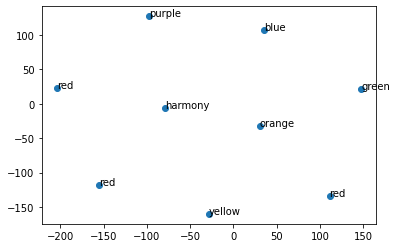

In [ ]:
Y = tsne.fit_transform(vectors[:1000])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")

plt.show()